<a href="https://colab.research.google.com/github/sachin-cw/Springboard-Capstone/blob/master/Quora_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment using Long Short Term Neural Network on Quora Sincere-Insincere Questions Classification.

Load all the dependencies, create a dictionary for expanding Contractions and have all the functions created.

In [0]:
!pip install ipython-autotime
%load_ext autotime
# above lines get me the cell execution time.

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#above lines help me avoid warnings thrown by sklearn


import re
import os

import unicodedata

import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from datetime import datetime
from pytz import timezone
import time

from sklearn.model_selection import train_test_split

import sys

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve,precision_recall_fscore_support

nltk.download('stopwords')

# Load stop words
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')



CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}






from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
  #  classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


  



def remove_special_chars(text):
  return re.sub(r'[^a-zA-Z0-9 \']', '', text)

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def tokenize_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token.strip() for token in tokens]
  return tokens

def normalize_text(text):
  text=remove_special_chars(text)
  text=expand_contractions(text)
  text=remove_accented_chars(text)
  return text

def remove_stopwords_nltk(tokens):
  filtered_tokens = [token for token in tokens if token not in stop_words]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text


def stem_sentences_nltk(sentence):
  ps = PorterStemmer()
  tokens = sentence.split()
  stemmed_tokens = [ps.stem(token) for token in tokens]
  return ' '.join(stemmed_tokens)
  
  
def stem_sentences_list(sentence):
  ps = PorterStemmer()
  tokens = sentence.split()
  stemmed_tokens = [ps.stem(token) for token in tokens]
  return stemmed_tokens

 
def tfidf_vectorize_get_array(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return np.array(vectorizer.fit_transform(series).todense(), dtype=np.float16)

def tfidf_vectorize(series):
  vectorizer = TfidfVectorizer(min_df=1,norm='l2',smooth_idf=True,use_idf=True,ngram_range=(1,1))
  return vectorizer.fit_transform(series)


def preprocess_text(df,stem=False):
  if stem:
    df['word_tokens_stemmed']=df['question_text'].apply(normalize_text).apply(tokenize_text).apply(remove_stopwords_nltk).apply(stem_sentences_nltk)
  else:
    df['word_tokens_preprocessed']=df['question_text'].apply(normalize_text)
  return df




def split_train_test(df,stem=False):
  if stem:
    x_train,x_test,y_train,y_test = train_test_split(df['word_tokens_stemmed'],df['target'], random_state=1,stratify=df['target'])
  else:
    x_train,x_test,y_train,y_test = train_test_split(df['word_tokens_preprocessed'],df['target'], random_state=1,stratify=df['target'])
  return x_train,x_test,y_train,y_test

def classifier_reports(y_test, y_pred):
  print()
  class_names = ['class0', 'class1']
  print(classification_report(y_test, y_pred, target_names=class_names))
  # Plot non-normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names,title='Confusion matrix, without normalization')
  # Plot normalized confusion matrix
  plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
  plt.show()
  
  


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=f8a47206ee29176c40e711b9a9e79f0a0acfd7831c63644ff45d43b8ef93e73b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mount the Google drive to load the training file later.

In [0]:

  
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/kaggle/quora')
!ls -ltr  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 12046755
-rw------- 1 root root 5646236541 Oct 24  2015 glove.840B.300d.txt
-rw------- 1 root root 2259088777 Mar 14  2018 wiki-news-300d-1M.vec
-rw------- 1 root root 3644258522 Oct 31  2018 GoogleNews-vectors-negative300.bin
drwx------ 2 root root       4096 Aug 25 19:03 paragram_300_sl999
-rw------- 1 root root   35011536 Aug 25 19:25 test.csv
-rw------- 1 root root  124206772 Aug 25 19:25 train.csv
-rw------- 1 root root    8643553 Aug 25 19:26 samp

Load the training and test file and preprocess it.

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df = pd.concat([train ,test])

print("Number of texts: ", df.shape[0])

Number of texts:  1681928
time: 4.99 s


In [0]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == 'wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file))
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

time: 5.85 ms


In [0]:
glove = 'glove.840B.300d.txt'
wiki_news = 'wiki-news-300d-1M.vec'

print("Extracting GloVe embedding")
embed_glove = load_embed(glove)

print("Extracting FastText embedding")
embed_fasttext = load_embed(wiki_news)

Extracting GloVe embedding
Extracting FastText embedding
time: 4min 20s


Define functions to build vocabulary from the dataset and check coverage of vocabulary in the pretrained embeddings

In [0]:
#vocab stores the frequency of each word found

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
  
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words  

time: 18.2 ms


In [0]:
vocab = build_vocab(df['question_text'])

time: 12.2 s


In [0]:
len(vocab)

597383

time: 11.1 ms


In [0]:
import operator
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 31.54% of vocab
Found embeddings for  88.16% of all text
FastText : 
Found embeddings for 28.40% of vocab
Found embeddings for  87.66% of all text
time: 1.63 s


If you have a word in embedding but it's small cased version is not in embedding, add an embedding for that small cased version.

In [0]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

time: 3.4 ms


In [0]:
print("Glove : ")
add_lower(embed_glove, vocab)

print("FastText : ")
add_lower(embed_fasttext, vocab)

Glove : 
Added 17744 words to embedding
FastText : 
Added 31871 words to embedding
time: 630 ms


Coverage as shown below is increased slightly.

In [0]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 31.82% of vocab
Found embeddings for  88.17% of all text
FastText : 
Found embeddings for 29.03% of vocab
Found embeddings for  87.70% of all text
time: 1.76 s


In [0]:
oov_glove[:10]

[('India?', 21063),
 ('it?', 16623),
 ("What's", 16104),
 ('do?', 11211),
 ('life?', 9993),
 ('you?', 8083),
 ('me?', 7982),
 ('them?', 7910),
 ('time?', 7379),
 ('world?', 6941)]

time: 4.25 ms


Check how many contractions are available in embeddings 

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

time: 7.27 ms


In [0]:
def known_contractions(embed):
    known = []
    for contract in contraction_mapping:
        if contract in embed:
            known.append(contract)
    return known

time: 6.43 ms


As shown below, there are a few known contractions found in Glove but none in FastText.

In [0]:
print("- Known Contractions -")
print("   Glove :")
print(known_contractions(embed_glove))

print("   FastText :")
print(known_contractions(embed_fasttext))

- Known Contractions -
   Glove :
["can't", "'cause", "didn't", "doesn't", "don't", "I'd", "I'll", "I'm", "I've", "i'd", "i'll", "i'm", "i've", "it's", "ma'am", "o'clock", "that's", "you'll", "you're"]
   FastText :
[]
time: 6.1 ms


Contractions could be formed using different apostrophe characters. Make it uniform in the data set so you can find their embedddings.

In [0]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

time: 4.18 ms


In [0]:
df['treated_question'] = df['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

time: 5.91 s


In [0]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 31.96% of vocab
Found embeddings for  88.41% of all text
FastText : 
Found embeddings for 29.16% of vocab
Found embeddings for  88.27% of all text
time: 14.7 s


As shown above, coverage increased slightly after making the apostrophes uniform across the dataset.

Check if there any unique punctuations not found in embeddings

In [0]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

time: 3.98 ms


In [0]:
print("Glove :")
print(unknown_punct(embed_glove, punct))

print("FastText :")
print(unknown_punct(embed_fasttext, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 
FastText :
_ ` 
time: 4.22 ms


Replace special characters with more generic ones or their word meanings.

In [0]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [0]:
df['treated_question'] = df['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

time: 36.7 s


In [0]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 73.14% of vocab
Found embeddings for  99.59% of all text
FastText : 
Found embeddings for 66.40% of vocab
Found embeddings for  99.48% of all text
time: 13.9 s


As shown above, coverage increased by around 10% with the above pre processing step.

In [0]:
oov_fasttext[:100]

[('Quorans', 1061),
 ('BITSAT', 712),
 ('COMEDK', 437),
 ('KVPY', 432),
 ('Quoran', 412),
 ('WBJEE', 300),
 ('articleship', 246),
 ('VITEEE', 232),
 ('UPES', 199),
 ('marksheet', 182),
 ('Fortnite', 168),
 ('AFCAT', 160),
 ('UCEED', 152),
 ('dropshipping', 149),
 ('UPSEE', 139),
 ('Machedo', 128),
 ('BNBR', 125),
 ('AMCAT', 121),
 ('IITian', 115),
 ('IITJEE', 112),
 ('JIIT', 95),
 ('Qoura', 95),
 ('ICOs', 94),
 ('NMAT', 93),
 ('LNMIIT', 90),
 ('MAINS', 87),
 ('hairfall', 86),
 ('bhakts', 82),
 ('NICMAR', 82),
 ('INFJs', 81),
 ('Kavalireddi', 81),
 ('Zerodha', 80),
 ('Vajiram', 79),
 ('WooCommerce', 75),
 ('Doklam', 73),
 ('Unacademy', 72),
 ('AlShamsi', 72),
 ('MUOET', 70),
 ('chsl', 69),
 ('HackerRank', 66),
 ('Gixxer', 65),
 ('Awdhesh', 65),
 ('Modiji', 64),
 ('Bhakts', 62),
 ('PUBG', 61),
 ('eLitmus', 60),
 ('SIBM', 58),
 ('MNIT', 57),
 ('AIQ', 57),
 ('MeToo', 56),
 ('CHSL', 53),
 ('SRMJEE', 52),
 ('Binance', 49),
 ('Skripal', 49),
 ('BMSCE', 47),
 ('Whatare', 46),
 ('Alshamsi', 46)

time: 6.8 ms


In [0]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

time: 5.91 ms


In [0]:
df['treated_question'] = df['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

time: 18.6 s


In [0]:
vocab = build_vocab(df['treated_question'])
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

print("FastText : ")
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 73.14% of vocab
Found embeddings for  99.59% of all text
FastText : 
Found embeddings for 66.41% of vocab
Found embeddings for  99.48% of all text
time: 14.8 s


In [0]:
df.head()

,qid,question_text,target,treated_question
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0,How did Quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0,"Do you have an adopted dog , how would you en..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0,Why does velocity affect time ? Does velocity...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0,How did Otto von Guericke used the Magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0,Can I convert montra helicon D to a mountain b...


time: 37.8 ms


# Above pre processing was to increase coverage of the tokens in embeddings. 


Apply the preprocessing steps defined above to the training dataset.

In [0]:
# Lowering
train['treated_question'] = train['question_text'].apply(lambda x: x.lower())
# Contractions
train['treated_question'] = train['treated_question'].apply(lambda x: clean_contractions(x, contraction_mapping))
# Special characters
train['treated_question'] = train['treated_question'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
# Spelling mistakes
train['treated_question'] = train['treated_question'].apply(lambda x: correct_spelling(x, mispell_dict))

time: 48.6 s


In [0]:
import gc
gc.collect()
train.head()

,qid,question_text,target,treated_question
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"do you have an adopted dog , how would you en..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time ? does velocity...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...


time: 176 ms


Instantiate Tokenizer and fit it on preprocessed text.

In [0]:
tokenizer = Tokenizer(num_words = 38987)
tokenizer.fit_on_texts(train['treated_question'])
print('Found %d unique words.' % len(tokenizer.word_index))

Found 195936 unique words.
time: 28.9 s


Translate the raw as well as preprocessed data into encodings.

In [0]:
len_voc = 95000
max_len = 60
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def make_data(X):
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

time: 3.41 ms


In [0]:
X, word_index = make_data(train['question_text'])

time: 1min


In [0]:
X_treated, word_index_treated = make_data(train['treated_question'])

time: 59.6 s


Split raw and preprocessed data into train and validation set.

In [0]:
from sklearn.model_selection import train_test_split
y = train['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=420,stratify=y)

X_t_train, X_t_val, _, _ = train_test_split(X_treated, y, test_size=0.1, random_state=420,stratify=y)


time: 1.95 s


In [0]:
print(f"Training on {X_train.shape[0]} texts")

Training on 1175509 texts
time: 1.61 ms


Define a function to create embedding matrices for our vocabulary ( unique words in the dataset) in raw and preprocessed data using pre trained word embeddings.

In [0]:
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

time: 8.06 ms


In [0]:
embedding = make_embed_matrix(embed_glove, word_index, len_voc)

del word_index
gc.collect()

embedding_treated = make_embed_matrix(embed_glove, word_index_treated, len_voc)
del word_index_treated
gc.collect()

  

0

time: 20.5 s


Define a Keras backend function for calculating F1


In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

time: 8.51 ms


In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Bidirectional, CuDNNGRU, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Input, Dropout
from keras.optimizers import Adam

time: 5.47 ms


In [0]:
from keras.layers import LSTM

def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp    = Input(shape=(max_len,))
    x      = Embedding(len_voc, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x      = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(x)    
      
    dense  = Dense(64, activation="relu")(x)
    drop   = Dropout(0.1)(x)
    output = Dense(1, activation="sigmoid")(x)
    
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['accuracy', f1])
    return model

time: 8.06 ms


In [0]:
model = make_model(embedding)
model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           28500000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 28,719,777
Trainable params: 219,777
Non-trainable params: 28,500,000
_________________________________________________________________
time: 5.52 s


In [0]:
model_treated = make_model(embedding_treated)

time: 720 ms


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint('weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

checkpoints_treated = ModelCheckpoint('treated_weights.hdf5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)
reduce_lr_treated = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=2, verbose=1, min_lr=0.000001)

time: 5.36 ms


Fit the model on raw data



Train on 1175509 samples, validate on 130613 samples
Epoch 1/8
1175509/1175509 [==============================] - 331s 281us/step - loss: 0.1439 - acc: 0.9466 - f1: 0.4168 - val_loss: 0.1217 - val_acc: 0.9514 - val_f1: 0.5303

Epoch 00001: val_f1 improved from -inf to 0.53025, saving model to weights.hdf5
Epoch 2/8
1175509/1175509 [==============================] - 330s 281us/step - loss: 0.1242 - acc: 0.9513 - f1: 0.5204 - val_loss: 0.1178 - val_acc: 0.9533 - val_f1: 0.5378

Epoch 00002: val_f1 improved from 0.53025 to 0.53781, saving model to weights.hdf5
Epoch 3/8
1175509/1175509 [==============================] - 332s 282us/step - loss: 0.1196 - acc: 0.9529 - f1: 0.5424 - val_loss: 0.1141 - val_acc: 0.9548 - val_f1: 0.5625

Epoch 00003: val_f1 improved from 0.53781 to 0.56251, saving model to weights.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/8
1175509/1175509 [==============================] - 333s 283us/step - loss: 0.1168 - ac

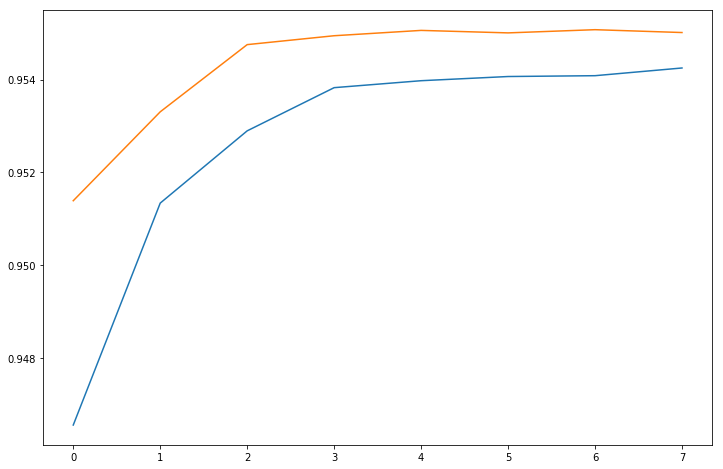

time: 44min 22s


In [0]:
epochs = 8
batch_size = 512

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=[X_val, y_val], callbacks=[checkpoints, reduce_lr])

plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()



Fit the model on processed data

Train on 1175509 samples, validate on 130613 samples
Epoch 1/8
1175509/1175509 [==============================] - 334s 284us/step - loss: 0.1458 - acc: 0.9456 - f1: 0.4104 - val_loss: 0.1226 - val_acc: 0.9515 - val_f1: 0.5017

Epoch 00001: val_f1 improved from -inf to 0.50170, saving model to treated_weights.hdf5
Epoch 2/8
1175509/1175509 [==============================] - 333s 284us/step - loss: 0.1238 - acc: 0.9514 - f1: 0.5219 - val_loss: 0.1168 - val_acc: 0.9531 - val_f1: 0.5553

Epoch 00002: val_f1 improved from 0.50170 to 0.55527, saving model to treated_weights.hdf5
Epoch 3/8
1175509/1175509 [==============================] - 334s 284us/step - loss: 0.1191 - acc: 0.9530 - f1: 0.5439 - val_loss: 0.1137 - val_acc: 0.9545 - val_f1: 0.5712

Epoch 00003: val_f1 improved from 0.55527 to 0.57120, saving model to treated_weights.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/8
1175509/1175509 [==============================] - 333s 284us/st

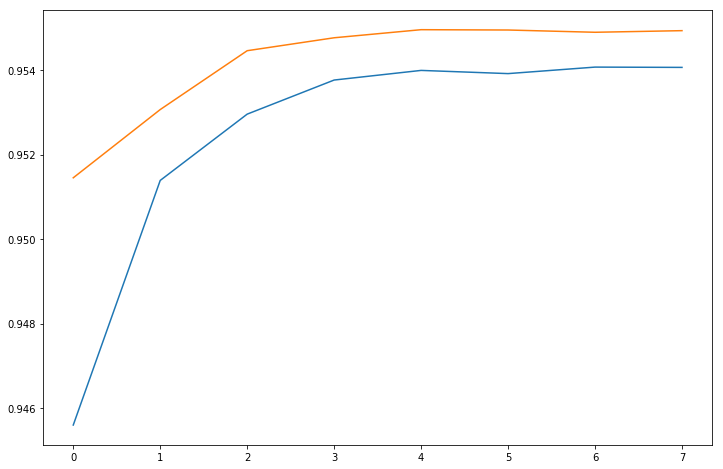

time: 44min 28s


In [0]:
history = model_treated.fit(X_t_train, y_train, batch_size=batch_size, epochs=epochs, 
                            validation_data=[X_t_val, y_val], callbacks=[checkpoints_treated, reduce_lr_treated])
                                                                         
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.show()
                                                                         
                                                                         

Load the best models created using raw and processed data and perform predictions using both of them.

In [0]:
model.load_weights('weights.hdf5')
model_treated.load_weights('treated_weights.hdf5')

pred_val = model.predict(X_val, batch_size=512, verbose=1)
pred_t_val = model_treated.predict(X_t_val, batch_size=512, verbose=1)

130613/130613 [==============================] - 15s 116us/step
time: 32.1 s


Define a function to find the threshold with best F1 score.

In [0]:
from sklearn.metrics import f1_score

def tweak_threshold(pred, truth):
    thresholds = []
    scores = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        thresholds.append(thresh)
        score = f1_score(truth, (pred>thresh).astype(int))
        scores.append(score)
    return np.max(scores), thresholds[np.argmax(scores)]

time: 7.2 ms


In [0]:
score_val, threshold_val = tweak_threshold(pred_val, y_val)

print(f"Scored {round(score_val, 4)} for threshold {threshold_val} with untreated texts on validation data")


score_t_val, threshold_t_val = tweak_threshold(pred_t_val, y_val)

print(f"Scored {round(score_t_val, 4)} for threshold {threshold_t_val} with treated texts on validation data")

Scored 0.6282 for threshold 0.31 with untreated texts on validation data
Scored 0.6276 for threshold 0.3 with treated texts on validation data
time: 2.94 s


Get the metrics of prediction using raw data.


              precision    recall  f1-score   support

      class0       0.98      0.97      0.97    122532
      class1       0.58      0.69      0.63      8081

    accuracy                           0.95    130613
   macro avg       0.78      0.83      0.80    130613
weighted avg       0.95      0.95      0.95    130613

Confusion matrix, without normalization
[[118467   4065]
 [  2521   5560]]
Normalized confusion matrix
[[0.96682499 0.03317501]
 [0.31196634 0.68803366]]


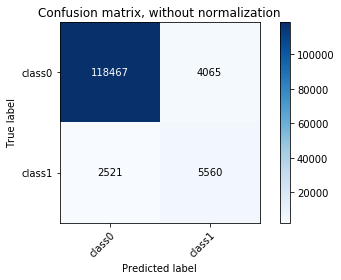

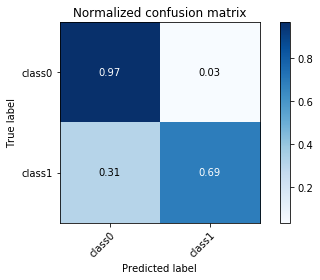

time: 893 ms


In [0]:
classifier_reports(y_val, (pred_val>0.30).astype(int))

Get the metrics for prediction using processed data.


              precision    recall  f1-score   support

      class0       0.98      0.96      0.97    122532
      class1       0.57      0.70      0.63      8081

    accuracy                           0.95    130613
   macro avg       0.77      0.83      0.80    130613
weighted avg       0.95      0.95      0.95    130613

Confusion matrix, without normalization
[[118210   4322]
 [  2409   5672]]
Normalized confusion matrix
[[0.96472758 0.03527242]
 [0.29810667 0.70189333]]


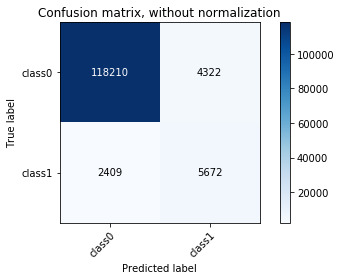

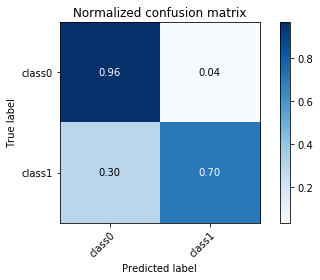

time: 1.18 s


In [0]:
classifier_reports(y_val, (pred_t_val>0.30).astype(int))

As seen above, there is a very minor improvement in recall of minority class by preprocessing the data.

Also, as seen in the preceding and following cells, comparing the thresholds of 0.3 and 0.5, it is evident that a threshold of 0.3 gives us the best possible metrics wrt classifying insincere questions. 



              precision    recall  f1-score   support

      class0       0.97      0.98      0.98    122532
      class1       0.68      0.52      0.59      8081

    accuracy                           0.95    130613
   macro avg       0.82      0.75      0.78    130613
weighted avg       0.95      0.95      0.95    130613

Confusion matrix, without normalization
[[120543   1989]
 [  3894   4187]]
Normalized confusion matrix
[[0.98376751 0.01623249]
 [0.48187106 0.51812894]]


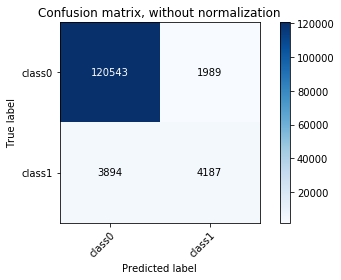

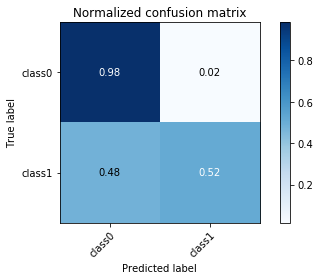

time: 964 ms


In [0]:
classifier_reports(y_val, (pred_t_val>0.50).astype(int))